 <p style= "background-color:#74bf65;font-family:Arial;color:#FFFFFF;font-size:200%;text-align:center;border-radius:20px 20px;border-style:solid;border-width:10px;border-color:#74bf65;"><b>Detección de anomalías y fraude bancario</b></p>
 
**Pablo Arriagada Ojeda | 2023**

Este proyecto se centra en la búsqueda y detección de anomalías en un conjunto masivo de datos, con el objetivo de detectar fraude en transacciones bancarias mediante el modelo no supervisado Isolation Forest. 

La medición del modelo se hará en base al Z-Score y a la comparación del área bajo la curva ROC.

El conjunto de datos fue obtenido desde https://www.kaggle.com/datasets/ealaxi/paysim1, estás son las variables que contiene:

- __'step'__ : Unidades de tiempo. 1 'step' corresponde a 1 hora. En total hay 744 steps (30 días)
- __'type'__ : Tipo de transacción (CASH-IN, CASH-OUT, DEBIT, PAYMENT y TRANSFER)
- __'nameOrig'__ : Cliente que empezó la transacción.
- __'oldbalanceOrg'__ : Balance inicial antes de la transacción.
- __'newbalanceOrig'__ : Balance final después de la transacción.
- __'nameDest'__: Cleinte que recibe la transacción.
- __'oldbalanceDest'__ : Balance inicial antes de la transacción.
- __'newbalanceDest'__ : Balance final después de la transacción.
- __'isFraud'__ : Estas son las transacciones realizadas por agentes fraudulentos dentro de la simulación. En este conjunto de datos específico, el comportamiento fraudulento de los agentes tiene como objetivo obtener beneficios tomando el control de las cuentas de los clientes y tratando de vaciar los fondos transfiriéndolos a otra cuenta y luego retirándolos del sistema.
- __'isFlaggedFraud'__ : El modelo de negocio tiene como objetivo controlar las transferencias masivas de una cuenta a otra y marcar intentos ilegales. Un intento ilegal en este conjunto de datos es un intento de transferir más de 200.000 en una sola transacción.

In [31]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
inicio = time.time()
df = pd.read_csv('financial_dataset.csv')

final = time.time()
tiempo_total = round((final - inicio),2)

print(f'La lectura del archivo CSV tomó {tiempo_total} segundos')

La lectura del archivo CSV tomó 9.36 segundos


# Paso 1: Preparación de los datos

Verificar que los datos no contengan nullos y estén etiquetados correctamente.

In [3]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


**Resumen de preparación de datos**

Podemos apreciar que el dataset contiene datos limpios y clasificados acorde a su tipo. No será necesario una etapa de limpieza.
***

# EDA

In [138]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

0    6354407
1       8213
Name: isFraud, dtype: int64


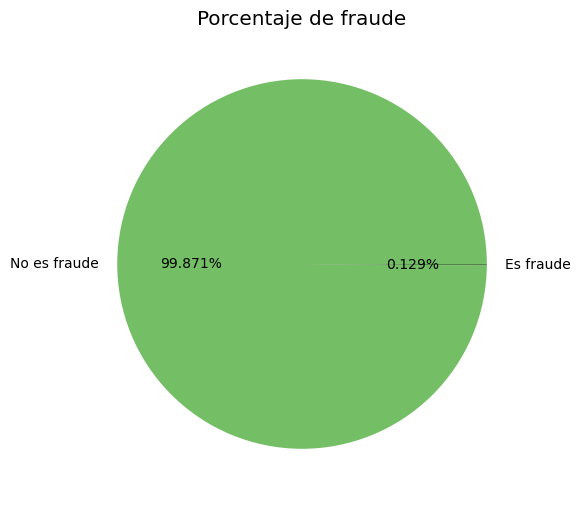

In [82]:
data = df['isFraud'].value_counts()

labels = ['No es fraude', 'Es fraude']
colors = ['#74bf65', '#518546']

plt.figure(figsize=(6, 6))
plt.pie(data, labels=labels, colors= colors, autopct='%1.3f%%', startangle=0)
plt.title('Porcentaje de fraude')

print(data)
plt.show()

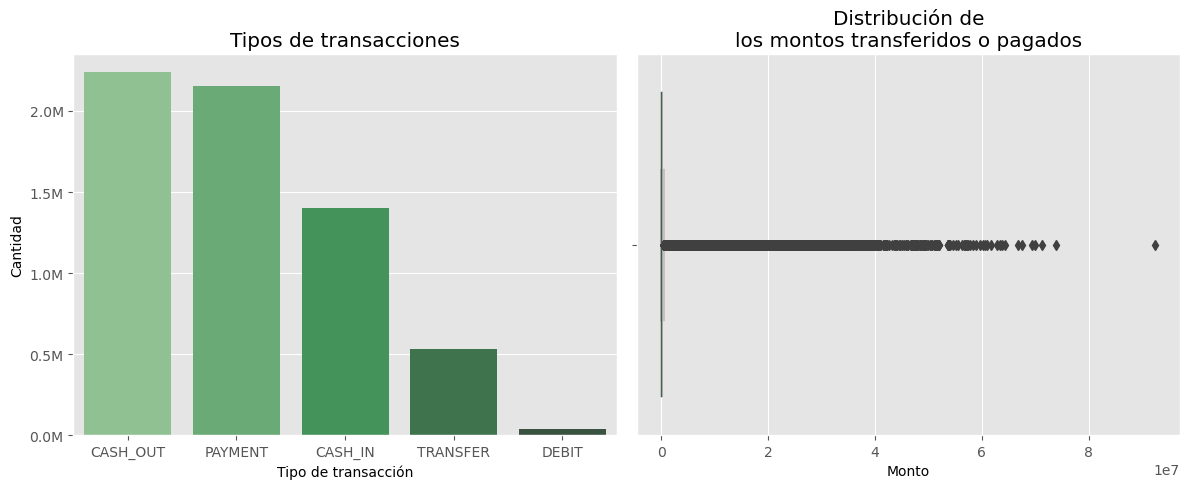

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.style.use('ggplot')
type_counts = df['type'].value_counts().sort_values(ascending=False)
ax1 = sns.countplot(data=df, x='type', palette='Greens_d', order=type_counts.index, ax=axes[0])
ax1.set_title('Tipos de transacciones')
ax1.set_xlabel('Tipo de transacción')
ax1.set_ylabel('Cantidad')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1e6) + 'M'))

plt.style.use('ggplot')
ax2 = sns.boxplot(data=df, x='amount', palette='Greens_d', linewidth=0.3, ax=axes[1])
ax2.set_title('Distribución de\nlos montos transferidos o pagados')
ax2.set_xlabel('Monto')


plt.tight_layout()
plt.show()

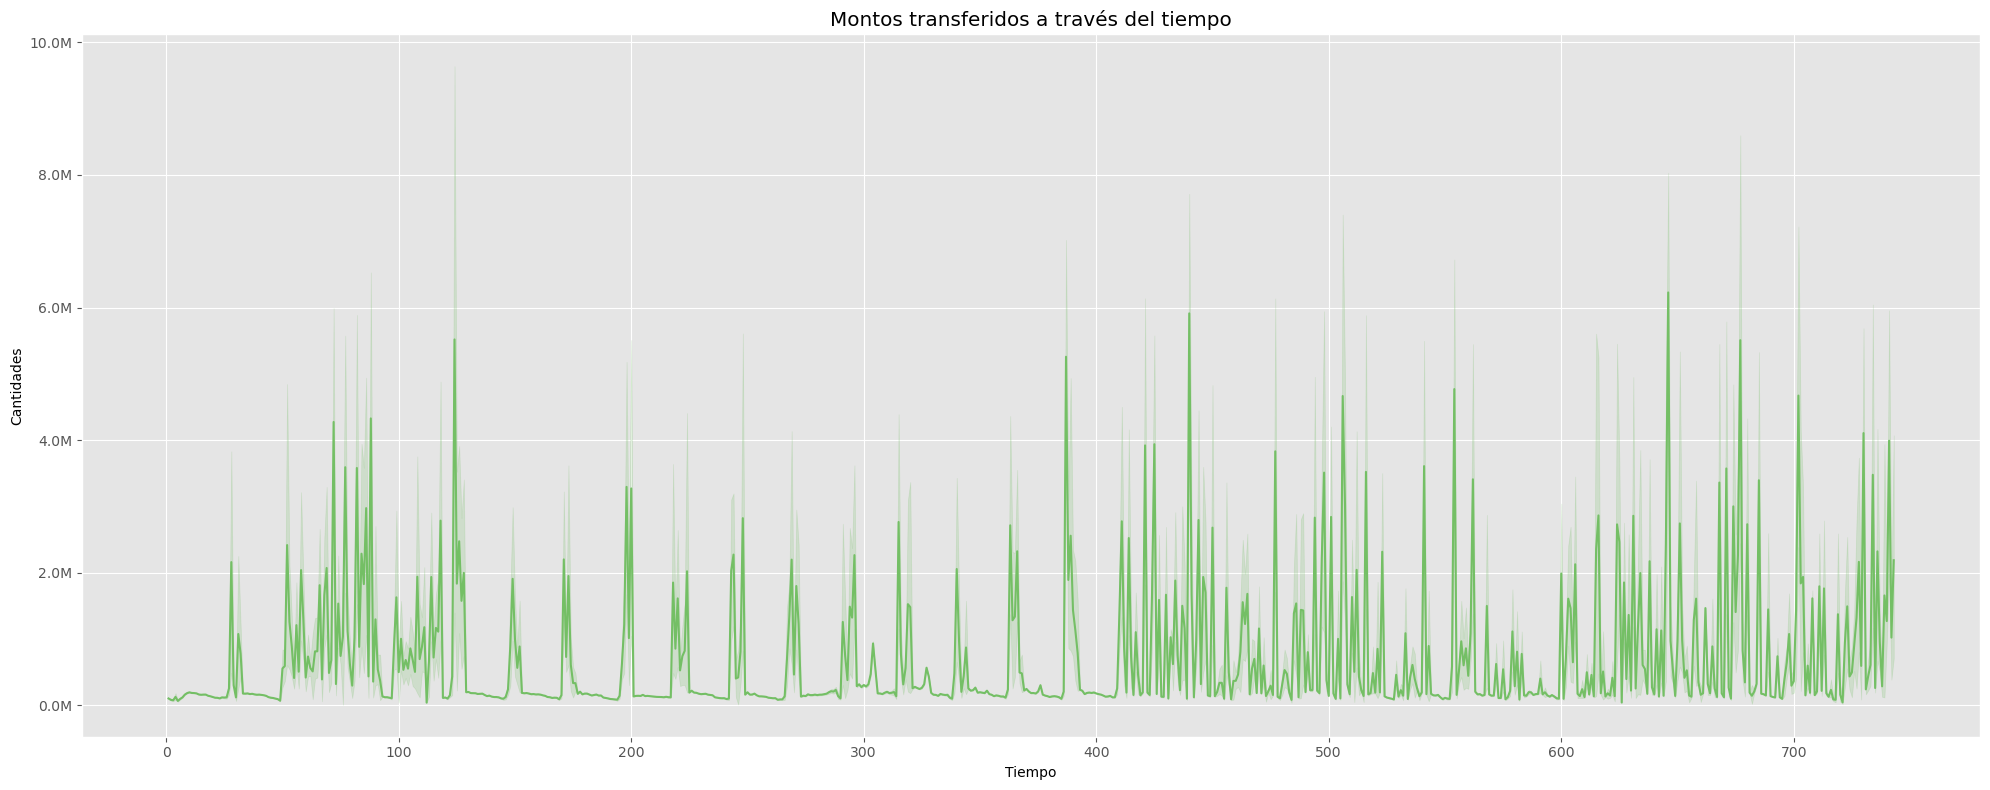

In [139]:
plt.style.use('ggplot')
plt.figure(figsize=(20,8))

ax= sns.lineplot(data= df, x= 'step', y= 'amount', color= '#74bf65')

plt.title('Montos transferidos a través del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Cantidades')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1e6) + 'M'))

plt.tight_layout()
plt.show()

# Feature Engineering

Una nueva variable que podemos generar es el cambio en el balance, el que nos permitirá ver cuánto cambian los montos en las cuentas después de cada transacción, de esta manera sería más cómodo identificar anomalías.

In [10]:
# Creamos columnas que muestren el cambio en las cuentas de origen y destino mediante el Change In Balance

df['changeBalanceOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['changeBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,changeBalanceOrig,changeBalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-181.00,-21182.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-11668.14,0.0


# Detección de anomalías
**Utilizando Isolation Forest**

Antes de aplicar el modelo de Isolation Forest, es necesario eliminar las columnas que sean innecesarias, como la etiqueta de si es fraude. Posteriormente aplicaremos un Label Encoder con el fin de generar dummies de las variables categóricas.

In [12]:
df_if = df.copy()
df_if = df_if.drop(columns= ['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'])

In [13]:
for col in df_if.columns:
    if df_if[col].dtype == 'object':
        le = LabelEncoder()
        df_if[col].fillna('None', inplace = True)
        le.fit(df_if[col].astype(str).values)
        df_if[col] = le.transform(list(df_if[col].astype(str).values))
    else:
        df_if[col].fillna(-999, inplace = True)

In [14]:
df_if.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeBalanceOrig,changeBalanceDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0
2,1,4,181.00,181.0,0.00,0.0,0.0,-181.00,0.0
3,1,1,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0


### Modelo Isolation Forest

In [18]:
contamination = 0.001

model_if = IsolationForest(contamination=contamination, random_state=42)
model_if.fit(df_if)

IsolationForest(contamination=0.001, random_state=42)

In [19]:
anomaly_scores = model_if.decision_function(df_if)

df_if['isolation_forest'] = model_if.predict(df_if)

df_if['anomaly_score_iforest'] = anomaly_scores

df_if.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeBalanceOrig,changeBalanceDest,isolation_forest,anomaly_score_iforest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,1,0.356130
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,1,0.370072
2,1,4,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,1,0.324250
3,1,1,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,1,0.354678
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,1,0.367674


In [20]:
df_if[df_if['isolation_forest'] == -1]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeBalanceOrig,changeBalanceDest,isolation_forest,anomaly_score_iforest
1818,1,4,2317408.88,4165916.16,1848507.28,14437052.95,16874643.09,-2317408.88,2437590.14,-1,-0.023316
6687,6,0,335389.99,11488141.21,11823531.20,17756311.00,18698748.85,335389.99,942437.85,-1,-0.009867
7121,6,0,343371.38,8855149.51,9198520.89,17324126.77,18056399.48,343371.38,732272.71,-1,-0.003405
10059,7,4,2943845.35,0.00,0.00,17993742.14,22641471.24,0.00,4647729.10,-1,-0.003145
10472,7,4,2316902.39,1170985.59,0.00,6647680.95,14646239.59,-1170985.59,7998558.64,-1,-0.001117
...,...,...,...,...,...,...,...,...,...,...,...
6362578,741,4,10000000.00,35674547.89,25674547.89,0.00,0.00,-10000000.00,0.00,-1,-0.018767
6362579,741,1,10000000.00,10000000.00,0.00,35922.97,10035922.97,-10000000.00,10000000.00,-1,-0.004830
6362580,741,4,10000000.00,25674547.89,15674547.89,0.00,0.00,-10000000.00,0.00,-1,-0.005510
6362581,741,1,10000000.00,10000000.00,0.00,0.00,10000000.00,-10000000.00,10000000.00,-1,-0.004830


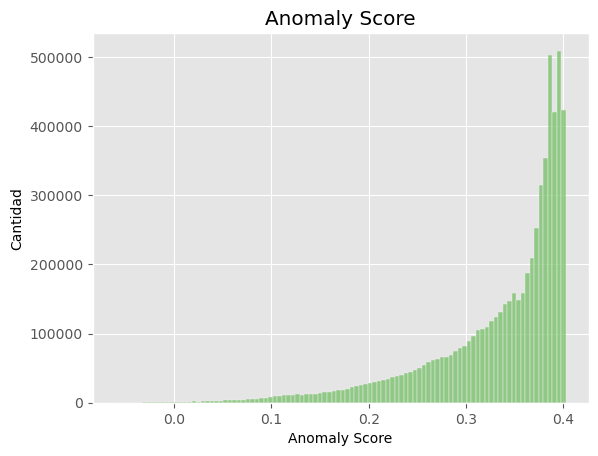

In [78]:
sns.histplot(data= df_if, bins= 100, x= 'anomaly_score_iforest', color= '#74bf65')

plt.title('Anomaly Score')
plt.xlabel('Anomaly Score')
plt.ylabel('Cantidad')

plt.show()

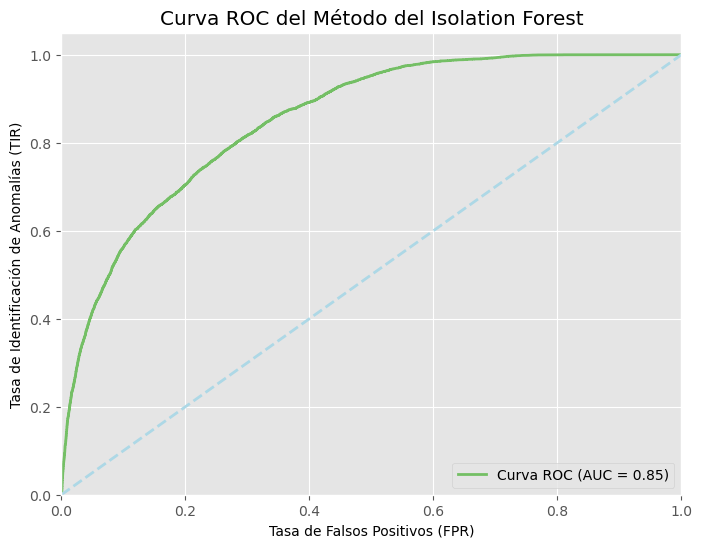

In [77]:
y_true = df['isFraud']

fpr, tir, thresholds = roc_curve(y_true, -anomaly_scores)

roc_auc = auc(fpr, tir)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tir, color='#74bf65', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Identificación de Anomalías (TIR)')
plt.title('Curva ROC del Método del Isolation Forest')
plt.legend(loc='lower right')

plt.show()

**Obtención del Z-Score**

Utilizando la formula del Z-Score, obtendremos este valor para cada observación.

$$z = (x-μ) / σ$$

In [41]:
mean_anomaly_score = df_if['anomaly_score_iforest'].mean()
std_anomaly_score = df_if['anomaly_score_iforest'].std()

In [42]:
df_if['z_score_iforest'] = (df_if['anomaly_score_iforest'] - mean_anomaly_score) / std_anomaly_score

In [44]:
df_if.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeBalanceOrig,changeBalanceDest,isolation_forest,anomaly_score_iforest,z_score_iforest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,1,0.356130,0.311877
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,1,0.370072,0.504341
2,1,4,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,1,0.324250,-0.128221
3,1,1,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,1,0.354678,0.291837
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,1,0.367674,0.471235


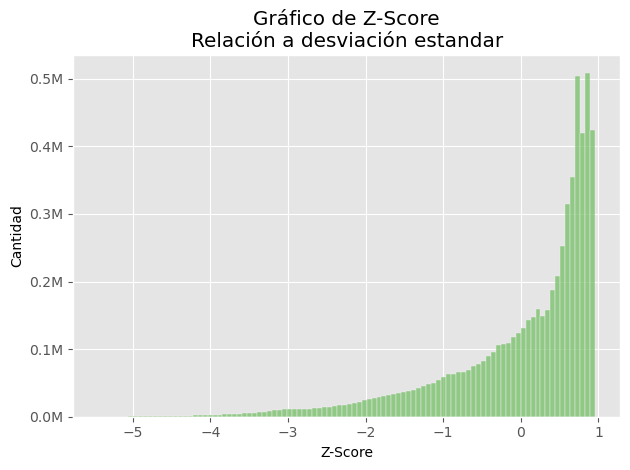

In [75]:
ax= sns.histplot(data= df_if, x= 'z_score_iforest', bins= 100, color='#74bf65')

plt.title('Gráfico de Z-Score\nRelación a desviación estandar')
plt.xlabel('Z-Score')
plt.ylabel('Cantidad')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1e6) + 'M'))

plt.tight_layout()
plt.show()

La mayor cantidad de datos están cercanos a 1 desviación estandar del 0. Por lo que, comparando con el boxplot de más arriba, podemos establecer que hay muchos valores que están lejanos, a más de 3 desviaciones estandar. Al definir un umbral de -4.5 de Z Score, podemos replicar de mejor manera la situación inicial del dataset, alrededor de 13% de datos fraudulentos.

In [59]:
threshold = -4.5  # Umbral Z-score
df_if['is_anomaly'] = df_if['z_score_iforest'] < threshold

In [109]:
df_if[(df_if['isolation_forest'] == -1) & (df_if['type'] == 4)]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeBalanceOrig,changeBalanceDest,isolation_forest,anomaly_score_iforest,z_score_iforest,is_anomaly
1818,1,4,2317408.88,4165916.16,1848507.28,14437052.95,16874643.09,-2317408.88,2437590.14,-1,-0.023316,-4.926335,True
10059,7,4,2943845.35,0.00,0.00,17993742.14,22641471.24,0.00,4647729.10,-1,-0.003145,-4.647872,True
10472,7,4,2316902.39,1170985.59,0.00,6647680.95,14646239.59,-1170985.59,7998558.64,-1,-0.001117,-4.619874,True
12539,7,4,797301.86,253442.46,0.00,14658353.25,23005385.41,-253442.46,8347032.16,-1,-0.004562,-4.667436,True
13908,7,4,160854.75,213911.29,53056.54,16117707.78,23005385.41,-160854.75,6887677.63,-1,-0.003034,-4.646342,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362456,730,4,10000000.00,37316255.05,27316255.05,0.00,0.00,-10000000.00,0.00,-1,-0.018767,-4.863535,True
6362458,730,4,10000000.00,27316255.05,17316255.05,0.00,0.00,-10000000.00,0.00,-1,-0.011448,-4.762503,True
6362576,741,4,10000000.00,45674547.89,35674547.89,0.00,0.00,-10000000.00,0.00,-1,-0.021333,-4.898962,True
6362578,741,4,10000000.00,35674547.89,25674547.89,0.00,0.00,-10000000.00,0.00,-1,-0.018767,-4.863535,True


### Definir baselines para comparar

- Random Guessig
- Naive anomaly score

El objetivo de esta operación es establecer baselines para luego comparar el rendimiento en base al área bajo una ROC curve

In [136]:
#Random Guessing

porcentaje_anomalias = 0.05
num_anomalias = int(len(df_if) * porcentaje_anomalias)

indices_anomalias = np.random.choice(len(df_if), num_anomalias, replace=False)
df_if['random_guessing'] = False
df_if.loc[indices_anomalias, 'random_guessing'] = True

In [127]:
#Naive anomaly score

df_if['naive_anomaly'] = abs(zscore(df_if['amount']))
umbral = 2 

# Etiquetar observaciones como anomalías basadas en el umbral
df_if['naive_anomaly'] = df_if['naive_anomaly'] > umbral

In [128]:
df_if.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changeBalanceOrig,changeBalanceDest,isolation_forest,anomaly_score_iforest,z_score_iforest,is_anomaly,random_guessing,naive_anomaly
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,-9839.64,0.0,1,0.356130,0.311877,False,False,False
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,-1864.28,0.0,1,0.370072,0.504341,False,False,False
2,1,4,181.00,181.0,0.00,0.0,0.0,-181.00,0.0,1,0.324250,-0.128221,False,False,False
3,1,1,181.00,181.0,0.00,21182.0,0.0,-181.00,-21182.0,1,0.354678,0.291837,False,False,False
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,-11668.14,0.0,1,0.367674,0.471235,False,False,False


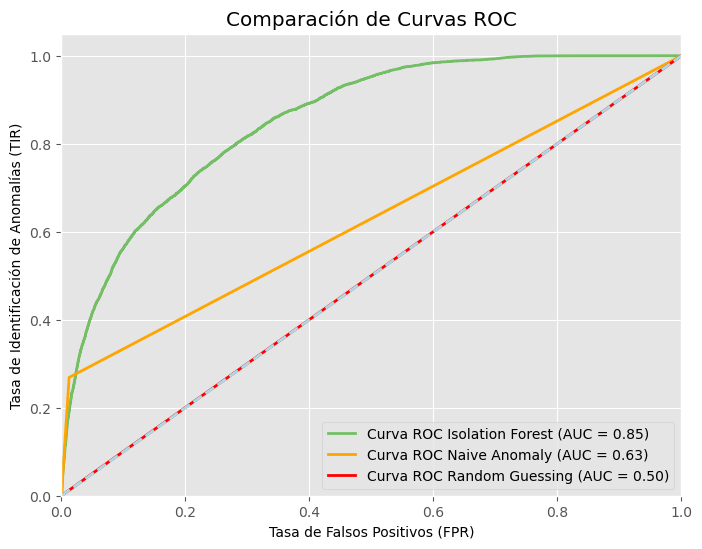

In [141]:
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC para el anomaly score "naive_anomaly"
fpr_naive, tir_naive, thresholds_naive = roc_curve(y_true, df_if['naive_anomaly'])
roc_auc_naive = auc(fpr_naive, tir_naive)

# Para el Isolation Forest
y_true = df['isFraud']
fpr, tir, thresholds = roc_curve(y_true, -anomaly_scores)
roc_auc = auc(fpr, tir)

# Curva ROC par ael anomaly score de RandomGuessing
fpr_random, tir_random, thresholds_random = roc_curve(y_true, df_if['random_guessing'])
roc_auc_random = auc(fpr_random, tir_random)

# Curva ROC
plt.figure(figsize=(8, 6))

plt.plot(fpr, tir, color='#74bf65', lw=2, label=f'Curva ROC Isolation Forest (AUC = {roc_auc:.2f})')
plt.plot(fpr_naive, tir_naive, color='orange', lw=2, label=f'Curva ROC Naive Anomaly (AUC = {roc_auc_naive:.2f})')
plt.plot(fpr_random, tir_random, color='red', lw=2, label=f'Curva ROC Random Guessing (AUC = {roc_auc_random:.2f})')
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Identificación de Anomalías (TIR)')
plt.title('Comparación de Curvas ROC')
plt.legend(loc='lower right')

plt.show()

# Conclusión

Como podemos observar en la comparación de la implementación de la curva ROC como métrica de evaluación, Isolation Forest presenta un buen desempeño respecto a Verdaderos Positivos y Verdaderos Negativos, los que nos lleva a una área bajo la curva de 0.85. Estos valores se acercan a lo idealista, pudiendo establecer que se trata de un buen ejercicio de práctica.

El fin personal de este proyecto tiene relación con hacer un acercamiento a la detección de anomalías, permitiendo aprender nuevos conceptos y metodologías de trabajo. 

**Pablo Arriagada Ojeda | 2023**